# Análisis de Series Temporales - Trabajo Práctico 1

Integrantes:

* Bermejo, Joaquín
* Scarafía, Franco
* Seward, Gerard

## 1. Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import pmdarima as pm
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

## 2. Carga de datasets

In [2]:
df = pd.read_csv('input/viajes_bici.csv')

df_train = df[df['fecha'] < '2024-01-01']
df_test  = df[df['fecha'] >= '2024-01-01']

df_train = df_train.set_index('fecha')
df_test  = df_test.set_index('fecha')

df_train.index = pd.to_datetime(df_train.index, format='%Y-%m-%d')
df_test.index  = pd.to_datetime(df_test.index, format='%Y-%m-%d')

In [3]:
eco_train = df_train[df_train['destino'] == 'Fac. Ciencias Económicas']
eco_test  = df_test[df_test['destino'] == 'Fac. Ciencias Económicas']

med_train = df_train[df_train['destino'] == 'Fac. Medicina']
med_test  = df_test[df_test['destino'] == 'Fac. Medicina']

ing_train = df_train[df_train['destino'] == 'Fac. de Ingeniería']
ing_test  = df_test[df_test['destino'] == 'Fac. de Ingeniería']

## 3. Funciones auxiliares

In [8]:
# Imputar ceros por la media
# eco_train['viajes'] = eco_train['viajes'].replace(0, eco_train['viajes'].mean())

In [7]:
# Evaluar graficamente que transformacion aplicar para estabilizar la variancia
# avg = eco_train.groupby([pd.Grouper(key='fecha', freq='W-MON')])['viajes'].mean().reset_index().sort_values('fecha').viajes
# sd = eco_train.groupby([pd.Grouper(key='fecha', freq='W-MON')])['viajes'].std().reset_index().sort_values('fecha').viajes
# plt.scatter(avg, sd)

In [36]:
# Intento de aplicar transformaciones para corregir la heterocedasticidad (no funcionaron)
# eco_train['viajes_modif'] = np.sqrt(eco_train.viajes.values + 3/8)
# eco_train['viajes_modif'] = np.log(eco_train.viajes.values)

In [5]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
  print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
  dftest = adfuller(series, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)
  if dftest[1] <= 0.05:
    print("Conclusion:====>")
    print("Rechazar la hipótesis nula")
    print("Los datos son estacionarios.")
  else:
    print("Conclusion:====>")
    print("No rechazar la hipótesis nula")
    print("Los datos no son estacionarios.")

In [4]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'): # [3]
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Gráfico de analisys de Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [14]:
def evaluar_metricas(serie_test, serie_pred):
    print(f'MSE:  {round(mean_squared_error(serie_test, serie_pred),2)}')
    print(f'MAE:  {round(mean_absolute_error(serie_test, serie_pred),2)}')
    print(f'RMSE: {round(np.sqrt(mean_squared_error(serie_test, serie_pred)),2)}')
    print(f'MAPE: {round(np.mean(abs((serie_test-serie_pred)/serie_test)),4)}')

In [40]:
def pronosticos_simples(train, test):
    forecasts = {}
    
    # Average
    forecasts['avg'] = len(test)*[train['viajes'].sum() / len(train)]
    
    # Naive
    forecasts['naive'] = len(test)*[train['viajes'][-1]]
    
    # Naive estacional
    forecasts['naive_s'] = np.tile(train['viajes'].iloc[-7:].values, int(np.ceil(len(test) / 7)))[:len(test)]
    
    # Drift
    m = (y_t - train.iloc[0]['viajes']) / len(train)
    h = np.linspace(0, len(test)-1, len(test))
    forecasts['drift'] = train.iloc[-1]['viajes'] + m * h

    metrics = []
    fmethods = ['avg', 'drift', 'naive', 'naive_s']
    
    for fmethod in fmethods:
        metrics.append([
            round(mean_squared_error(test['viajes'], forecasts[fmethod]), 2),
            round(mean_absolute_error(test['viajes'], forecasts[fmethod]), 2),
            round(np.sqrt(mean_squared_error(test['viajes'], forecasts[fmethod])), 2),
            round(np.mean(abs((test['viajes']-forecasts[fmethod])/test['viajes'])), 4)
        ])

    metrics_df = pd.DataFrame(metrics, index=fmethods, columns=['MSE', 'MAE', 'RMSE', 'MAPE'])
    print(metrics_df)

## 4. Análisis de series

### 4.a. Fac. Ciencias Económicas

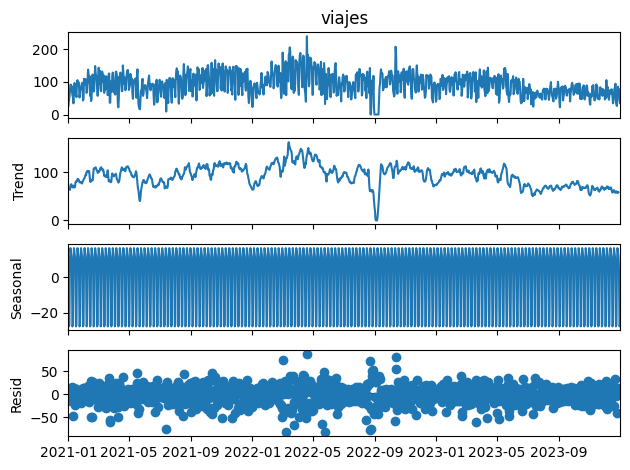

In [40]:
result = seasonal_decompose(eco_train['viajes'], model="additive")
result.plot();

Se detecta un componente estacional de período 7 (semanal).

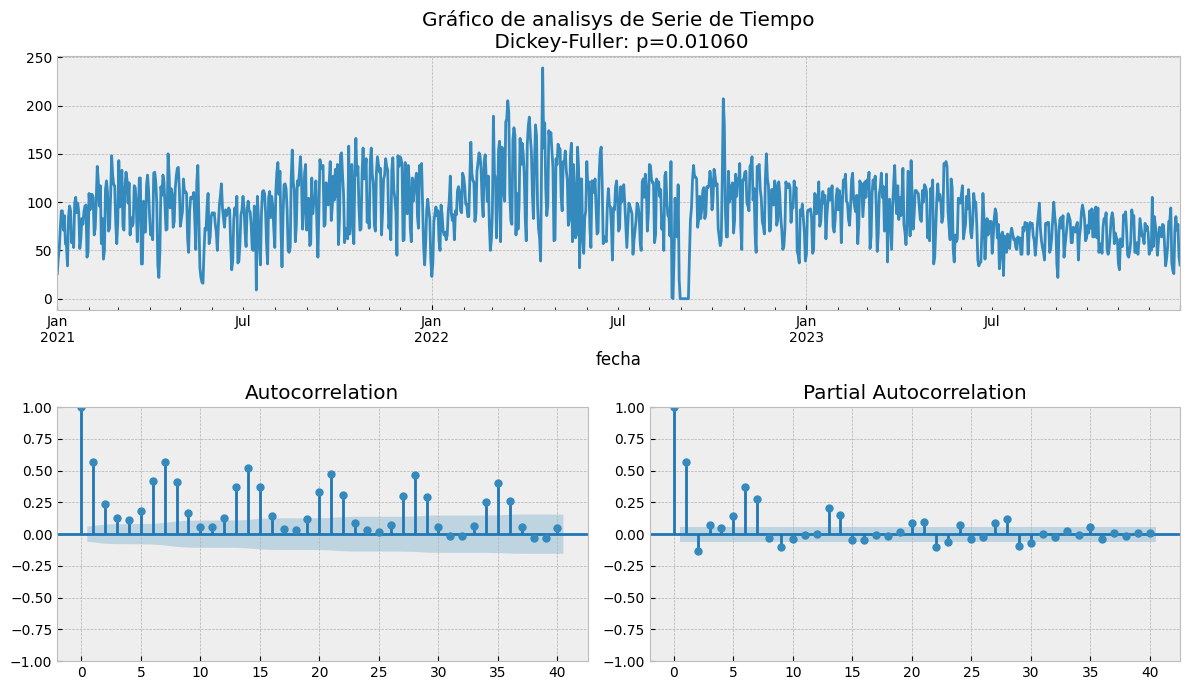

In [41]:
tsplot(eco_train['viajes'], lags = 40);

Observaciones:

* Una estacionalidad semestral en la serie, con máximos a mitad de cada semestre y mínimos en los extremos.
* Un p-value significativo del test de raíces unitarias.
* Una recurrencia de picos en la función de autocorrelación, cada 7 lags.
* Un decaimiento veloz de los primeros lags en la función de autocorrelación.
* Un decaimiento lento de la autocorrelación en los picos estacionales.
* En los lags regulares de la FACP, sólo el primer lag toma un valor significativo.
* En los lags estacionales de la FACP, los lags $7k-1$ y $7k$ son significativos y positivos.

Conclusiones (a partir de lo observado):

* Estacionariedad en la parte regular.
* Presencia de un doble componente estacional: uno con frecuencia semanal y otro con frecuencia semestral (no pueden modelarse en conjunto).
* La parte regular podría ser un $AR(1)$ o similar.
* Quizás haya que aplicar una diferenciación estacional.
* La parte estacional podría ser un $ARMA(1,1)$ o similar.

Se procede entonces a aplicar una **diferenciación estacional** y evaluar el resultado.

In [5]:
ecoD1 = eco_train.viajes.values[7:] - eco_train.viajes.values[:-7]
ecoD1 = np.concatenate([ecoD1, 7*[0]])
eco_train['viajes_D1'] = ecoD1

C:\Users\PC\AppData\Local\Temp\ipykernel_6636\2522106940.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eco_train['viajes_D1'] = ecoD1


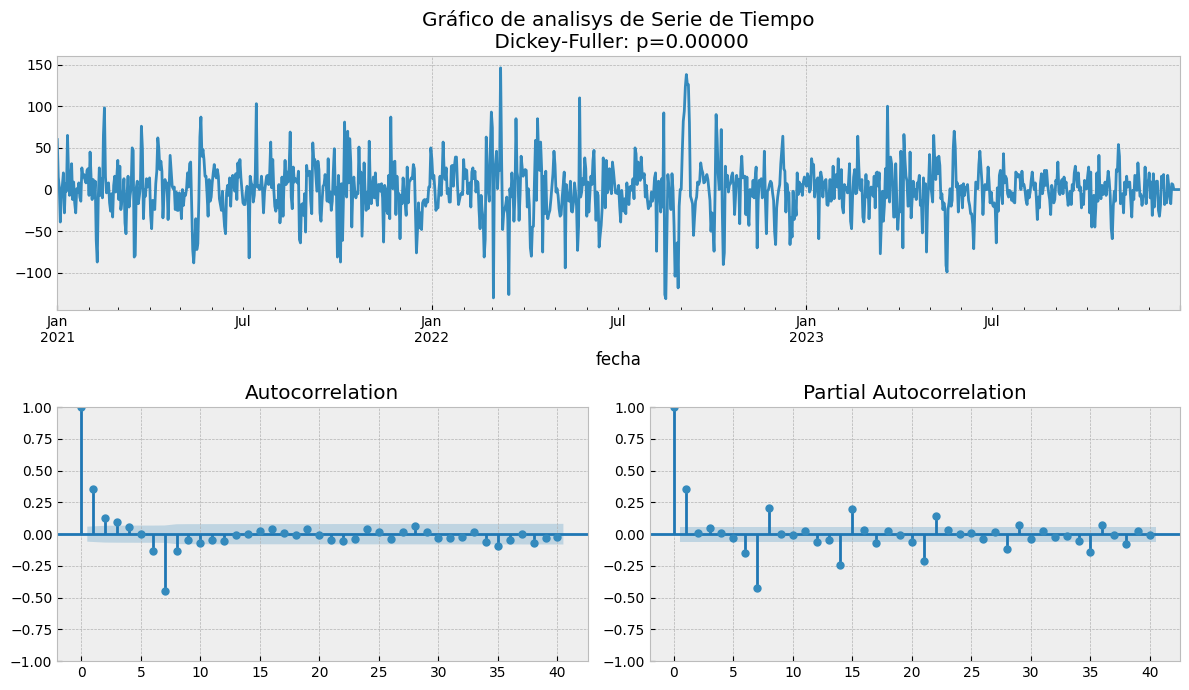

In [43]:
tsplot(eco_train['viajes_D1'], lags = 40);

Observaciones:

* La diferenciación estacional parece haber simplificado el comportamiento de la FAC.
* En la FAC, la parte regular decae velozmente y en la parte estacional sólo un lag (el 7) resulta significativo.
* En la FACP, la parte regular sólo muestra un lag significativo, mientras que la parte estacional muestra múltiples pares adyacentes de lags significativos.

Conclusiones (a partir de lo observado):

* La parte regular podría ser un $AR(1)$ o similar.
* La parte estacional podría ser un $ARMA(1,1)$ o similar.

In [44]:
model_eco = auto_arima(
    eco_train['viajes'],
    start_p=0, start_q=0,
    d=0, D=1,
    max_p=2, max_q=2,
    max_P=2, max_Q=2,
    test='adf',
    m=7, seasonal=True, # periodicidad estacional
    trace=True, error_action='ignore', suppress_warnings=True, stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=10195.403, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=10610.289, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=10191.345, Time=0.25 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=9990.961, Time=0.34 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=10608.291, Time=0.00 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=10481.370, Time=0.11 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=9983.746, Time=0.36 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=10216.175, Time=0.22 sec
 ARIMA(0,0,1)(2,1,1)[7] intercept   : AIC=9980.329, Time=1.49 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=10126.379, Time=0.41 sec
 ARIMA(0,0,1)(2,1,2)[7] intercept   : AIC=9982.770, Time=1.46 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : AIC=10183.415, Time=1.01 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=inf, Time=2.29 sec
 ARIMA(0,0,2)(2,1,1)[7] intercept  

In [6]:
modelo_final_eco = SARIMAX(eco_train['viajes'], order=(1, 0, 1), seasonal_order=(2, 1, 2, 7))
resultado_eco = modelo_final_eco.fit()

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


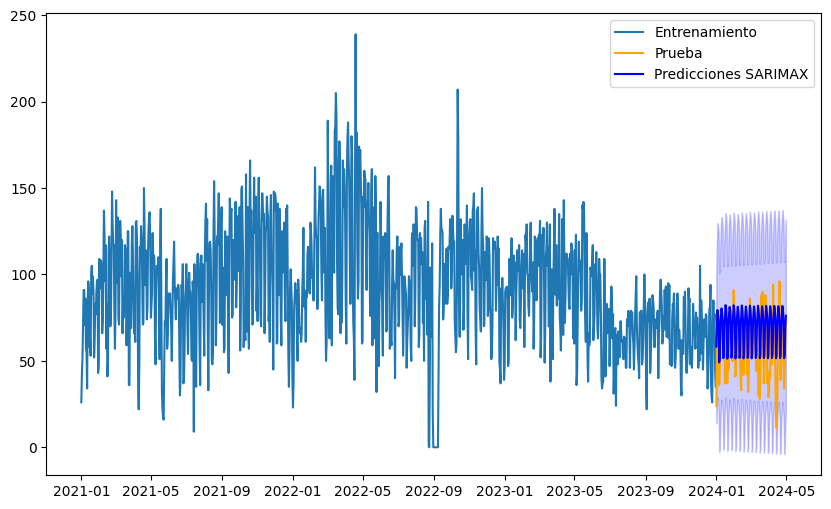

In [7]:
# Predicciones del modelo
pred_eco = resultado_eco.get_forecast(steps=121)
pred_ci_eco = pred_eco.conf_int()


plt.figure(figsize=(10, 6))
plt.plot(eco_train.index, eco_train['viajes'], label='Entrenamiento')
plt.plot(eco_test.index, eco_test['viajes'], label='Prueba', color='orange')
plt.plot(eco_test.index, pred_eco.predicted_mean, label='Predicciones SARIMAX', color='blue')
plt.fill_between(eco_test.index, pred_ci_eco.iloc[:, 0], pred_ci_eco.iloc[:, 1], color='blue', alpha=0.2)
plt.legend()
plt.show()

In [17]:
print("Métricas de performance del pronóstico")
evaluar_metricas(eco_test['viajes'], pred_eco.predicted_mean)

Métricas de performance del pronóstico
MSE:  334.29
MAE:  14.19
RMSE: 18.28
MAPE: 0.3491


En su capacidad predictiva, el modelo seleccionado presenta un error absoluto medio de 14 viajes.

Los pronósticos difieren en un 35% de los valores observados.

¿Cómo se compara esto con otros pronósticos más sencillos?

In [41]:
pronosticos_simples(eco_train, eco_test)

             MSE    MAE   RMSE    MAPE
avg      1440.67  34.07  37.96  0.8082
drift     792.75  24.15  28.16  0.3990
naive     814.05  24.53  28.53  0.4039
naive_s   443.20  16.09  21.05  0.3269


C:\Users\PC\AppData\Local\Temp\ipykernel_6636\1242341496.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts['naive'] = len(test)*[train['viajes'][-1]]


El único de estos pronósticos que supera el modelo propuesto es el naive estacional, aunque sólo es mejor respecto a la métrica MAPE.

In [46]:
resultado_eco.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                 viajes   No. Observations:                 1095
Model:             SARIMAX(1, 0, 1)x(2, 1, [1, 2], 7)   Log Likelihood               -4944.488
Date:                                Tue, 24 Dec 2024   AIC                           9902.977
Time:                                        17:23:18   BIC                           9937.922
Sample:                                    01-01-2021   HQIC                          9916.204
                                         - 12-31-2023                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7034      0.034     20.995      0.000       0.638       0.769
ma.L1         -0.2653      0.042     -6.263      0.000      -0.348      -0.182
ar.S.L7       -0.7563      0.134     -5.661      0.000      -1.018      -0.494
ar.S.L14       0.0895      0.027      3.299      0.001       0.036       0.143
ma.S.L7       -0.1119      0.133     -0.842      0.400      -0.372       0.149
ma.S.L14      -0.7637      0.119     -6.421      0.000      -0.997      -0.531
sigma2       512.3365     13.373     38.312      0.000     486.126     538.547
===================================================================================
Ljung-Box (L1) (Q):                   0.58   Jarque-Bera (JB):               670.00
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

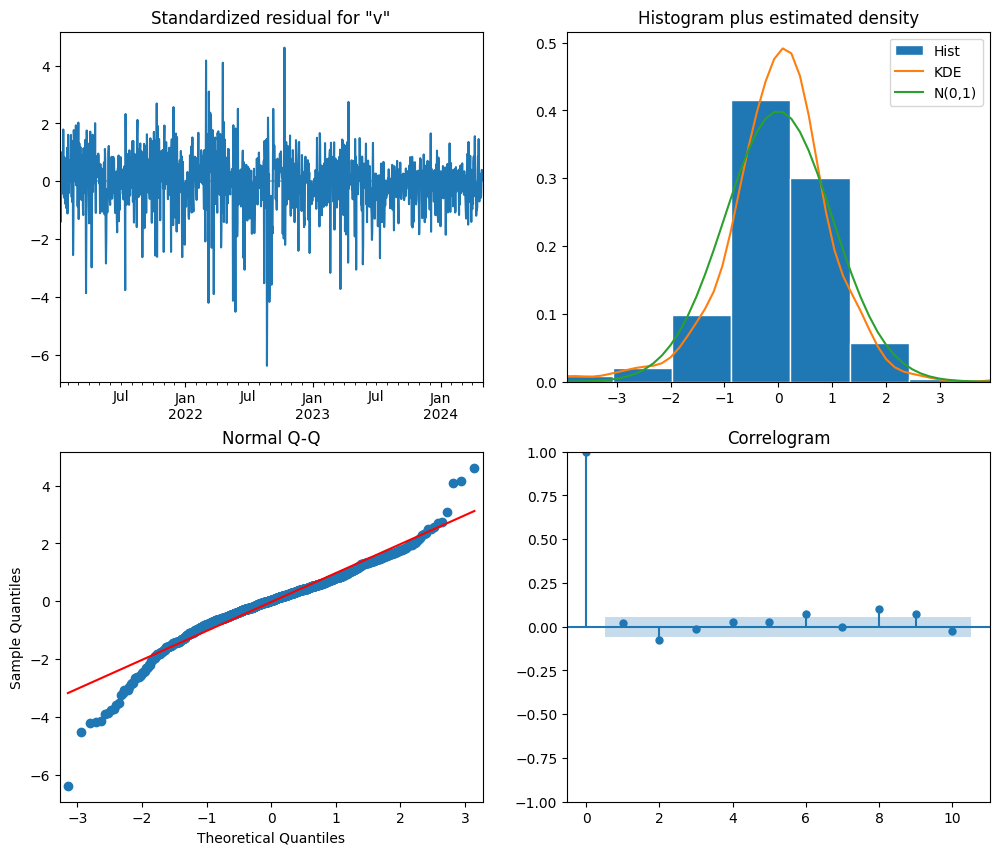

In [27]:
fig_res_eco = resultado_eco.plot_diagnostics(figsize=(12,10))

* **Ljung-Box:** los residuos no exhiben correlación serial ($p=0.44$).
    * Se cumple el supuesto de incorrelación de los residuos.
* **Jarque-Bera:** los residuos no siguen una distibución Normal ($p<0.01$).
    * No se cumple el supuesto de Normalidad de los residuos.
* **Heterocedasticidad:** los residuos tienen varianza variable en el tiempo ($p < 0.01$).
    * No se cumple el supuesto de homocedasticidad.

### 4.b. Fac. Medicina

In [8]:
result = seasonal_decompose(med_train['viajes'], period=7)
result.plot();

El grafico para seasonal es una linea lo cual indica que no se trata de una serie con temporadas

In [7]:
tsplot(med_train['viajes'], lags = 40);

Diferenciar: El test de DF es de 0.09241, asi que se tendra que diferenciar la seria para transformarla en estacionaria

In [189]:
med_train['viajes_diff'] = med_train['viajes'].diff().dropna()
med_train.dropna(inplace=True)

C:\Users\PC\AppData\Local\Temp\ipykernel_12556\1514652850.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_med['viajes_diff'] = df_med['viajes'].diff().dropna()
C:\Users\PC\AppData\Local\Temp\ipykernel_12556\1514652850.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_med.dropna(inplace=True)


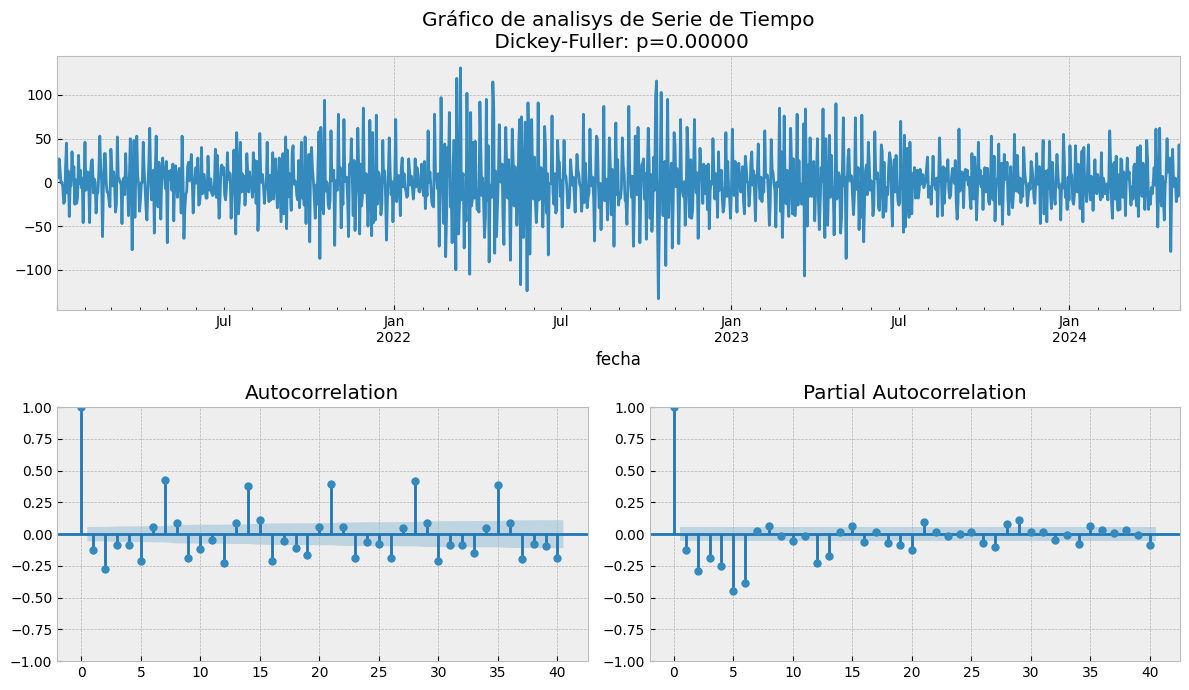

In [18]:
tsplot(med_train['viajes_diff'], lags = 40);

In [190]:
medD1 = med_train.viajes_diff.values[7:] - med_train.viajes_diff.values[:-7]
medD1 = np.concatenate([medD1, 7*[0]])
med_train['viajes_d1D1'] = medD1

C:\Users\PC\AppData\Local\Temp\ipykernel_12556\374634380.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_med['viajes_d1D1'] = medD1


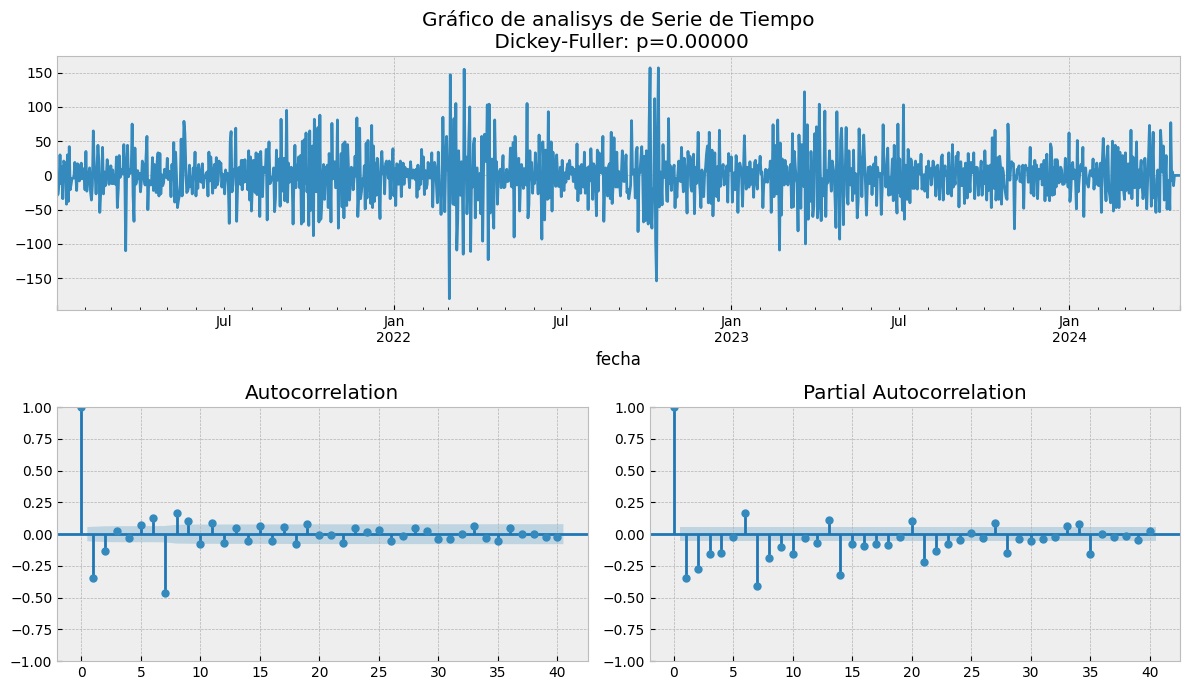

In [191]:
tsplot(med_train['viajes_d1D1'], lags = 40);

Diferenciar: El test de DF es de 0.00000, con lo cual se concluye que con la diferenciacion de 1er orden, es suficiente para volver la serie estacionaria
AR: Los primeros 6 lags son significativos. Proponer en AutoArima un max de AR = 6
MA: Los 7 primeros lags son significativos y luego entra en un patron con frecuencia igual a 7 lags. Proponer en AutoArima un max de MA = 7

In [ ]:
model_med = auto_arima(med_train['viajes'],
                       start_p=0,
                       d=1,
                       start_q=0,
                       start_Q=2,
                       start_P=0,
                       test='adf',
                       max_p=6,
                       max_d=1,
                       max_q=7,
                       max_P=0,
                       max_D=1,
                       max_Q=5,
                       m=7, #Representa la periodicidad estacional de la serie
                       seasonal=True, #Esto le permite a auto_arima considerar modelos estacionales
                       trace=True, #Muestra en pantalla el proceso de búsqueda de modelos
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=11753.125, Time=2.44 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=11968.796, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=11952.616, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=11582.543, Time=1.09 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=11966.798, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=11774.791, Time=0.24 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=11497.268, Time=4.82 sec
 ARIMA(0,1,1)(0,0,3)[7] intercept   : AIC=11443.389, Time=9.47 sec
 ARIMA(0,1,1)(0,0,4)[7] intercept   : AIC=11397.598, Time=18.75 sec
 ARIMA(0,1,1)(0,0,5)[7] intercept   : AIC=11380.975, Time=29.54 sec
 ARIMA(0,1,0)(0,0,5)[7] intercept   : AIC=11656.046, Time=10.63 sec
 ARIMA(1,1,1)(0,0,5)[7] intercept   : AIC=11230.133, Time=21.83 sec
 ARIMA(1,1,1)(0,0,4)[7] intercept   : AIC=11245.117, Time=16.42 sec
 ARIMA(1,1,0)(0,0,5)[7] intercept   : AIC=11567.667, Time=10.33 sec
 ARIMA(2,1,1)

In [82]:
model_med.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1215
Model:               SARIMAX(6, 1, 0)   Log Likelihood               -5620.615
Date:                Thu, 12 Dec 2024   AIC                          11255.231
Time:                        23:49:02   BIC                          11290.942
Sample:                    01-02-2021   HQIC                         11268.675
                         - 04-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5425      0.020    -26.858      0.000      -0.582      -0.503
ar.L2         -0.6483      0.021    -30.256      0.000      -0.690      -0.606
ar.L3         -0.5781      0.022    -25.966      0.000      -0.622      -0.534
ar.L4         -0.5598      0.024    -23.698      0.000      -0.606      -0.513
ar.L5         -0.5899      0.022    -27.372      0.000      -0.632      -0.548
ar.L6         -0.3883      0.022    -18.029      0.000      -0.430      -0.346
sigma2       613.7581     18.573     33.046      0.000     577.357     650.160
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               212.90
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.09
Prob(H) (two-sided):                  0.98   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Ljung +++ poca correlacion entre los residuos
- JB --- los residuos no tienen distibucion normal
- H +++ los residuos tienen varianza constante
- skew +++ residuos casi simetricos
- Kurtosis +o- residuos outliers 

In [10]:
modelo_final_med = SARIMAX(med_train['viajes'], order=(6, 1, 0), seasonal_order=(0, 0, 0, 0))
resultado_med = modelo_final_med.fit()

/home/ge/.virtualenvs/general/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ge/.virtualenvs/general/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.62630D+00    |proj g|=  2.20673D-03

At iterate    5    f=  4.62630D+00    |proj g|=  3.28749D-04

At iterate   10    f=  4.62630D+00    |proj g|=  2.17935D-04

At iterate   15    f=  4.62629D+00    |proj g|=  4.60543D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     17     20      1     0     0   3.453D-05   4.626D+00
  F =   4.6262945880485429     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


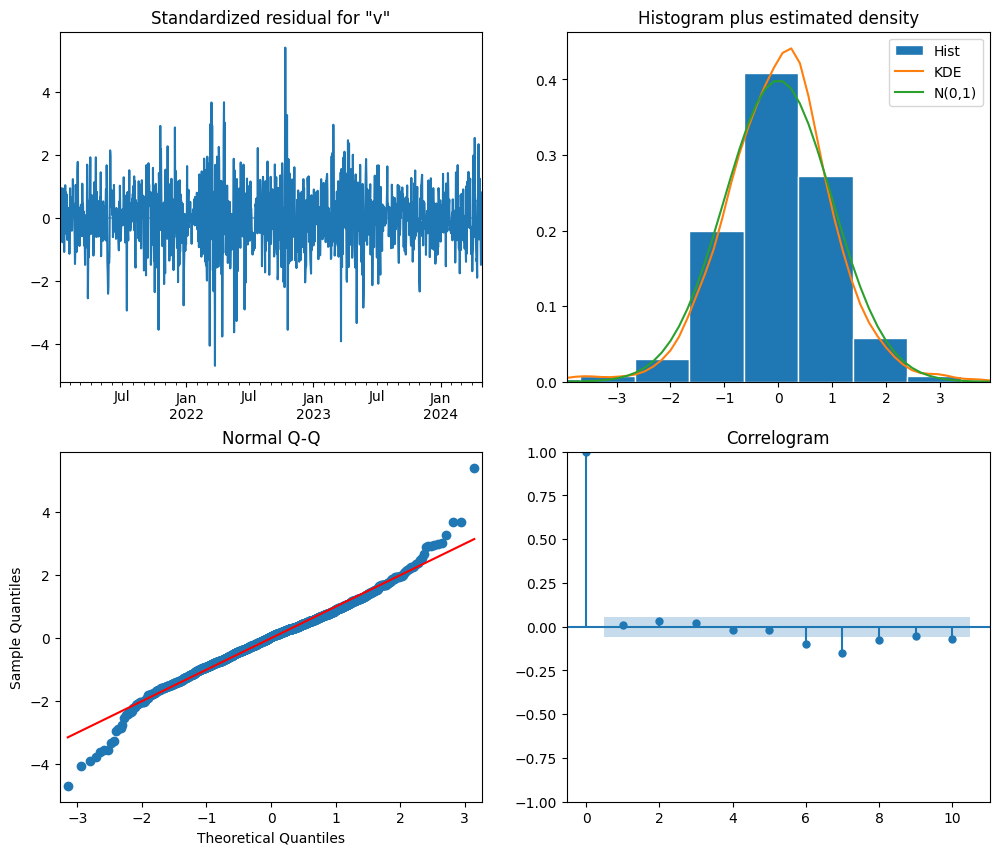

In [11]:
fig_res_med = resultado_med.plot_diagnostics(figsize=(12,10))

### 4.c. Fac. de Ingenieria

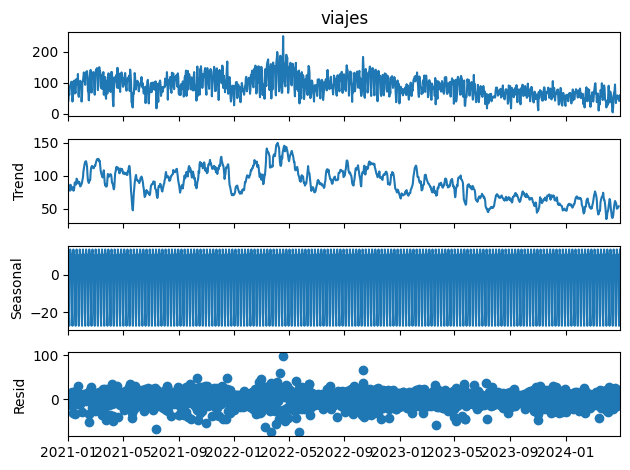

In [192]:
result = seasonal_decompose(ing_train['viajes'], period=7)
result.plot();

El grafico para seasonal es una linea lo cual indica que no se trata de una serie con temporadas

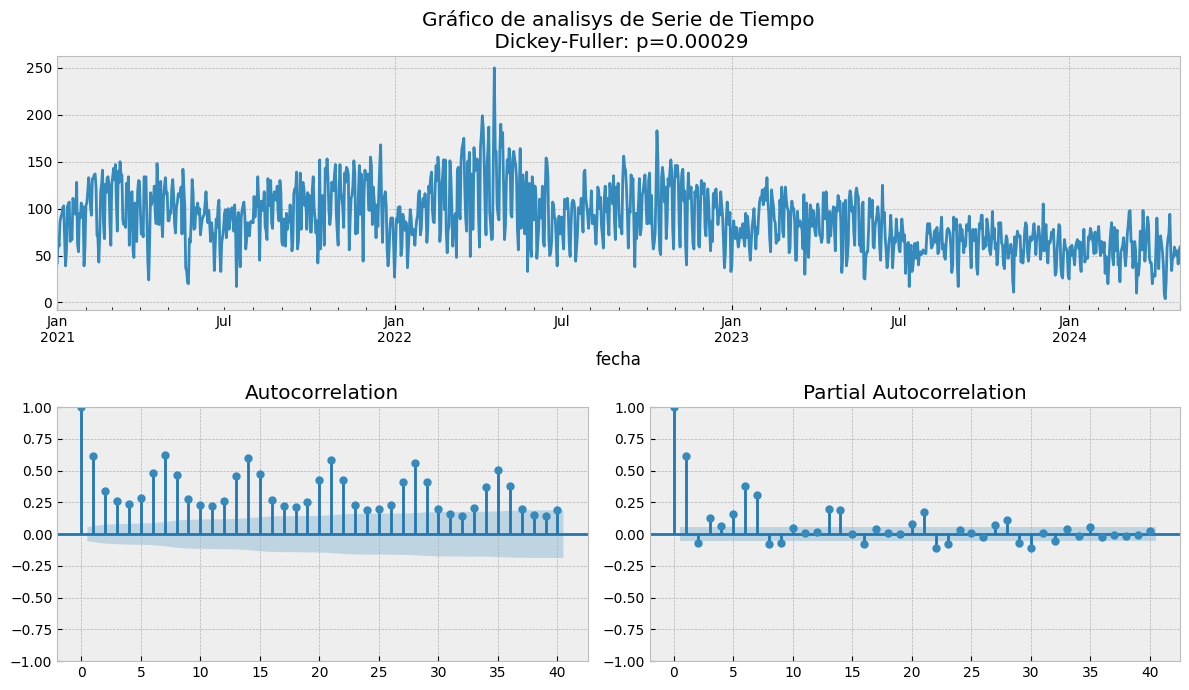

In [8]:
tsplot(ing_train['viajes'], lags = 40);

Diferenciar: El test de DF es de 0.17974, asi que se tendra que diferenciar la seria para transformarla en estacionaria

In [88]:
ing_train['viajes_diff'] = ing_train['viajes'].diff().dropna()
ing_train.dropna(inplace=True)

/tmp/ipykernel_2215/2062116121.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ing['viajes_diff'] = df_ing['viajes'].diff().dropna()
/tmp/ipykernel_2215/2062116121.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ing.dropna(inplace=True)


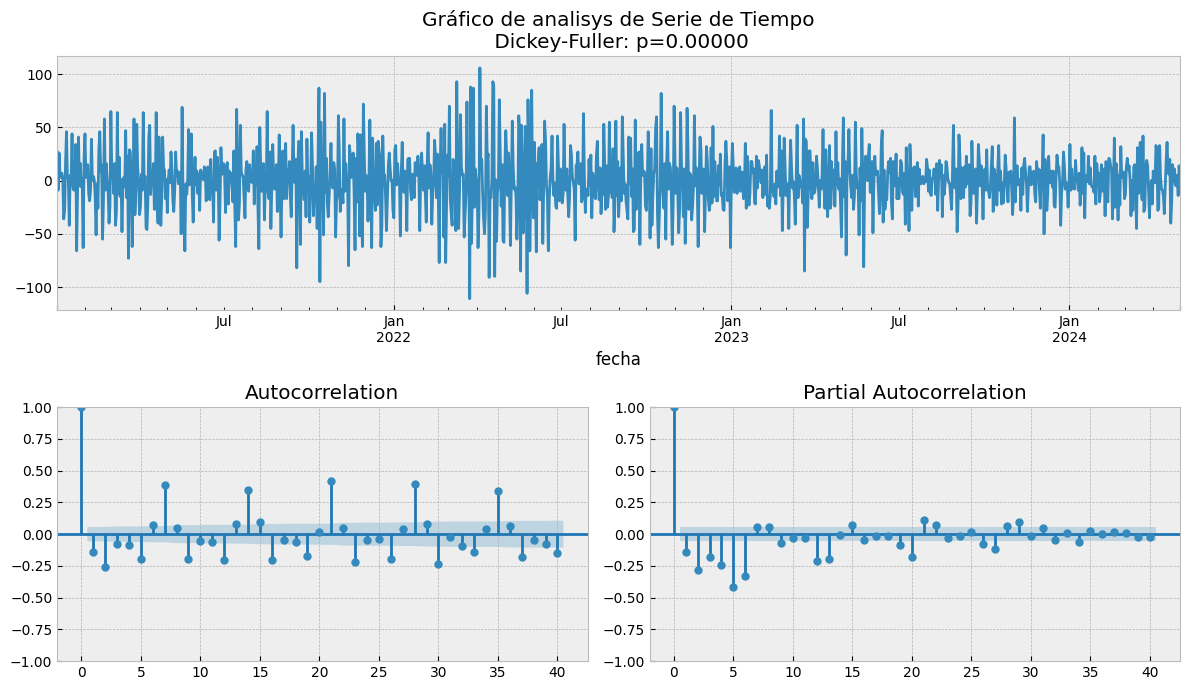

In [89]:
tsplot(ing_train['viajes_diff'], lags = 40);

Diferenciar: El test de DF es de 0.00000, con lo cual se concluye que con la diferenciacion de 1er orden, es suficiente para volver la serie estacionaria
AR: Los primeros 6 lags son significativos. Proponer en AutoArima un max de AR = 6
MA: Los 7 primeros lags son significativos y luego entra en un patron con frecuencia igual a 7 lags. Proponer en AutoArima un max de MA = 7

In [90]:
model_ing = auto_arima(ing_train['viajes'],
                       start_p=0,
                       d=1,
                       start_q=0,
                       test='adf',
                       max_p=6,
                       max_d=1,
                       max_q=7,
                       max_P=3,
                       max_D=1,
                       max_Q=3,
                       m=7, #Representa la periodicidad estacional de la serie
                       seasonal=False, #Esto le permite a auto_arima considerar modelos estacionales
                       trace=True, #Muestra en pantalla el proceso de búsqueda de modelos
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

/home/ge/.virtualenvs/general/lib/python3.12/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11596.778, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11575.667, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11413.247, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11594.778, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11225.069, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11157.334, Time=0.38 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11475.632, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11149.858, Time=0.44 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=11437.126, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=11111.018, Time=0.51 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=11365.057, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=11043.073, Time=0.77 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=11132.543, Time=0.36 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=10991.158, Time=1.91 sec
 ARIMA(6,1,0)(0,0,0

In [92]:
model_ing.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1215
Model:               SARIMAX(5, 1, 5)   Log Likelihood               -5376.349
Date:                Thu, 12 Dec 2024   AIC                          10776.698
Time:                        23:56:06   BIC                          10837.918
Sample:                    01-02-2021   HQIC                         10799.746
                         - 04-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.4093      0.144     -2.837      0.005      -0.692      -0.127
ar.L1          1.0744      0.045     24.103      0.000       0.987       1.162
ar.L2         -1.6548      0.035    -47.372      0.000      -1.723      -1.586
ar.L3          1.2066      0.061     19.620      0.000       1.086       1.327
ar.L4         -1.2049      0.036    -33.198      0.000      -1.276      -1.134
ar.L5          0.2809      0.041      6.896      0.000       0.201       0.361
ma.L1         -1.6123      0.035    -45.676      0.000      -1.682      -1.543
ma.L2          1.9785      0.044     44.626      0.000       1.892       2.065
ma.L3         -1.9377      0.042    -45.605      0.000      -2.021      -1.854
ma.L4          1.5191      0.041     37.384      0.000       1.439       1.599
ma.L5         -0.7779      0.030    -25.812      0.000      -0.837      -0.719
sigma2       460.9577     17.013     27.094      0.000     427.613     494.303
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):               252.16
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                            -0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Ljung +++ poca correlacion entre los residuos
- JB --- los residuos no tienen distibucion normal
- H --- los residuos tienen varianza variable en el tiempo
- skew --- residuos no simetricos
- Kurtosis --- muchos residuos outliers 

### 4.d. Plaza San Martin

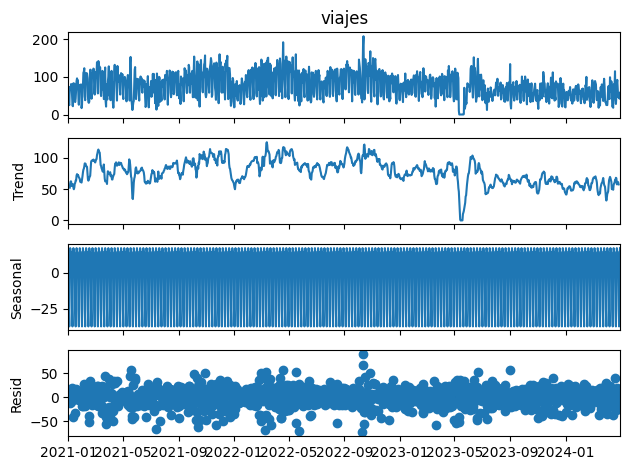

In [39]:
result = seasonal_decompose(df_martin['viajes'], period=7)
result.plot();

El grafico para seasonal es una linea lo cual indica que no se trata de una serie con temporadas

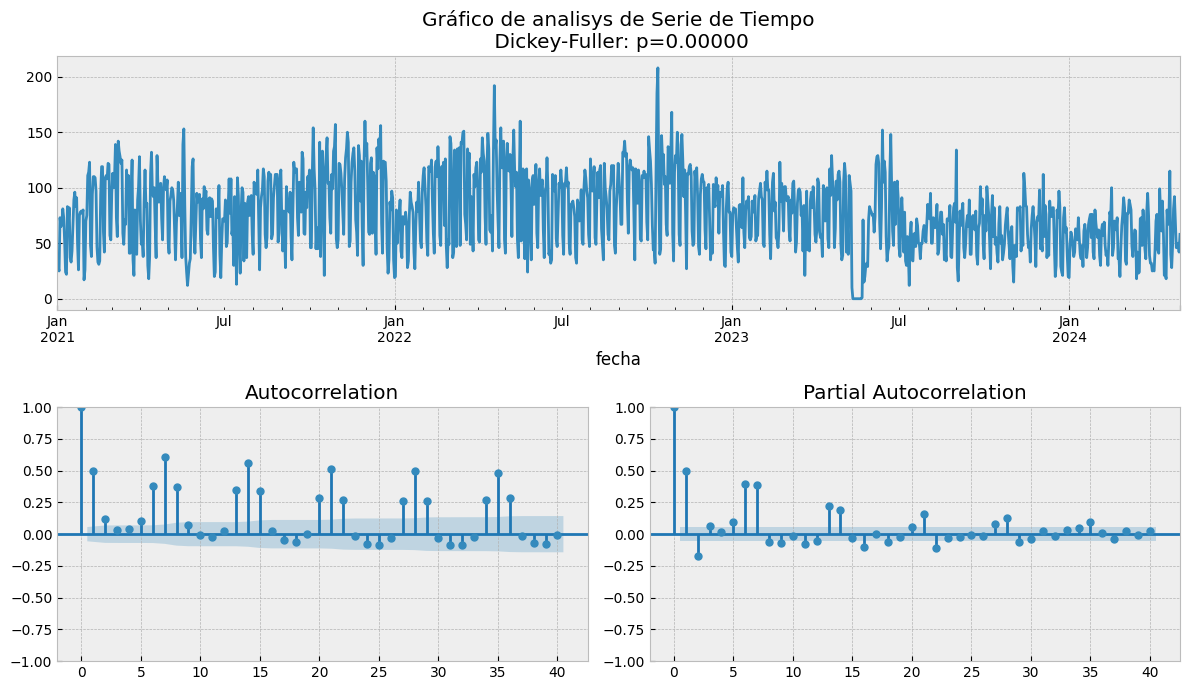

In [9]:
tsplot(df_martin['viajes'], lags = 40);

Diferenciar: El test de DF es de 0.00155 con lo cual se concluye que es una serie estacionaria
AR: Los primeros 6 lags son significativos. Proponer en AutoArima un max de AR = 6
MA: Los 7 primeros lags son significativos y luego entra en un patron con frecuencia igual a 7 lags. Proponer en AutoArima un max de MA = 7

In [20]:
model_martin = auto_arima(df_martin['viajes'],
                       start_p=0,
                       d=0,
                       start_q=0,
                       test='adf',
                       max_p=8,
                       max_d=1,
                       max_q=7,
                       max_P=3,
                       max_D=1,
                       max_Q=3,
                       m=7, #Representa la periodicidad estacional de la serie
                       seasonal=True, #Esto le permite a auto_arima considerar modelos estacionales
                       trace=True, #Muestra en pantalla el proceso de búsqueda de modelos
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=11588.689, Time=2.78 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=12001.133, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=11270.272, Time=1.04 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=11423.626, Time=1.02 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=14243.251, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=11661.949, Time=0.16 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=11157.683, Time=6.20 sec
 ARIMA(1,0,0)(3,0,0)[7] intercept   : AIC=11094.189, Time=12.93 sec
 ARIMA(1,0,0)(3,0,1)[7] intercept   : AIC=inf, Time=15.02 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=11068.166, Time=13.17 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=10986.479, Time=2.73 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=11430.140, Time=0.93 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=11040.750, Time=11.66 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=11337.463, Time=4.36 sec
 ARIMA(1,0,0)(2,0,2)[

In [21]:
model_martin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1216
Model:             SARIMAX(2, 0, 0)x(2, 0, [1], 7)   Log Likelihood               -5473.182
Date:                             Fri, 13 Dec 2024   AIC                          10958.364
Time:                                     20:34:04   BIC                          10988.984
Sample:                                 01-01-2021   HQIC                         10969.891
                                      - 04-30-2024                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3949      0.022     17.745      0.000       0.351       0.439
ar.L2          0.0896      0.024      3.669      0.000       0.042       0.138
ar.S.L7        1.0638      0.024     43.550      0.000       1.016       1.112
ar.S.L14      -0.0646      0.024     -2.653      0.008      -0.112      -0.017
ma.S.L7       -0.9288      0.013    -73.986      0.000      -0.953      -0.904
sigma2       466.8721     14.100     33.112      0.000     439.237     494.507
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               182.32
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.39
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
model_martin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1216
Model:               SARIMAX(7, 0, 4)   Log Likelihood               -5555.748
Date:                Fri, 13 Dec 2024   AIC                          11135.496
Time:                        20:26:29   BIC                          11196.736
Sample:                    01-01-2021   HQIC                         11158.550
                         - 04-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2782      0.028     45.395      0.000       1.223       1.333
ar.L2         -1.5291      0.045    -34.302      0.000      -1.616      -1.442
ar.L3          1.4822      0.059     25.019      0.000       1.366       1.598
ar.L4         -1.1381      0.065    -17.574      0.000      -1.265      -1.011
ar.L5          0.5748      0.059      9.688      0.000       0.458       0.691
ar.L6          0.1026      0.045      2.284      0.022       0.015       0.191
ar.L7          0.2287      0.028      8.227      0.000       0.174       0.283
ma.L1         -0.7603      0.017    -44.176      0.000      -0.794      -0.727
ma.L2          1.3377      0.016     84.116      0.000       1.306       1.369
ma.L3         -0.7592      0.016    -47.561      0.000      -0.791      -0.728
ma.L4          0.9042      0.016     57.409      0.000       0.873       0.935
sigma2       573.5465     19.368     29.614      0.000     535.587     611.506
===================================================================================
Ljung-Box (L1) (Q):                   2.60   Jarque-Bera (JB):               120.68
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                            -0.20
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Ljung +++ poca correlacion entre los residuos
- JB --- los residuos no tienen distibucion normal
- H --- los residuos tienen varianza variable en el tiempo
- skew +++ residuos simetricos
- Kurtosis --- muchos residuos outliers 

In [ ]:
modelo_final_martin = SARIMAX(df_martin['viajes'], order=(2, 0, 0), seasonal_order=(2, 0, 1, 7))
resultado_martin = modelo_final_martin.fit()


/home/ge/.virtualenvs/general/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ge/.virtualenvs/general/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.73489D+00    |proj g|=  1.38770D-01


 This problem is unconstrained.



At iterate    5    f=  4.66857D+00    |proj g|=  1.66083D-02

At iterate   10    f=  4.62331D+00    |proj g|=  9.37607D-02

At iterate   15    f=  4.51810D+00    |proj g|=  7.61312D-02

At iterate   20    f=  4.51029D+00    |proj g|=  2.48496D-03

At iterate   25    f=  4.50277D+00    |proj g|=  7.95237D-03

At iterate   30    f=  4.50098D+00    |proj g|=  1.26976D-03

At iterate   35    f=  4.50097D+00    |proj g|=  5.06394D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     47      1     0     0   3.056D-06   4.501D+00
  F =   4.5009721361403265     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

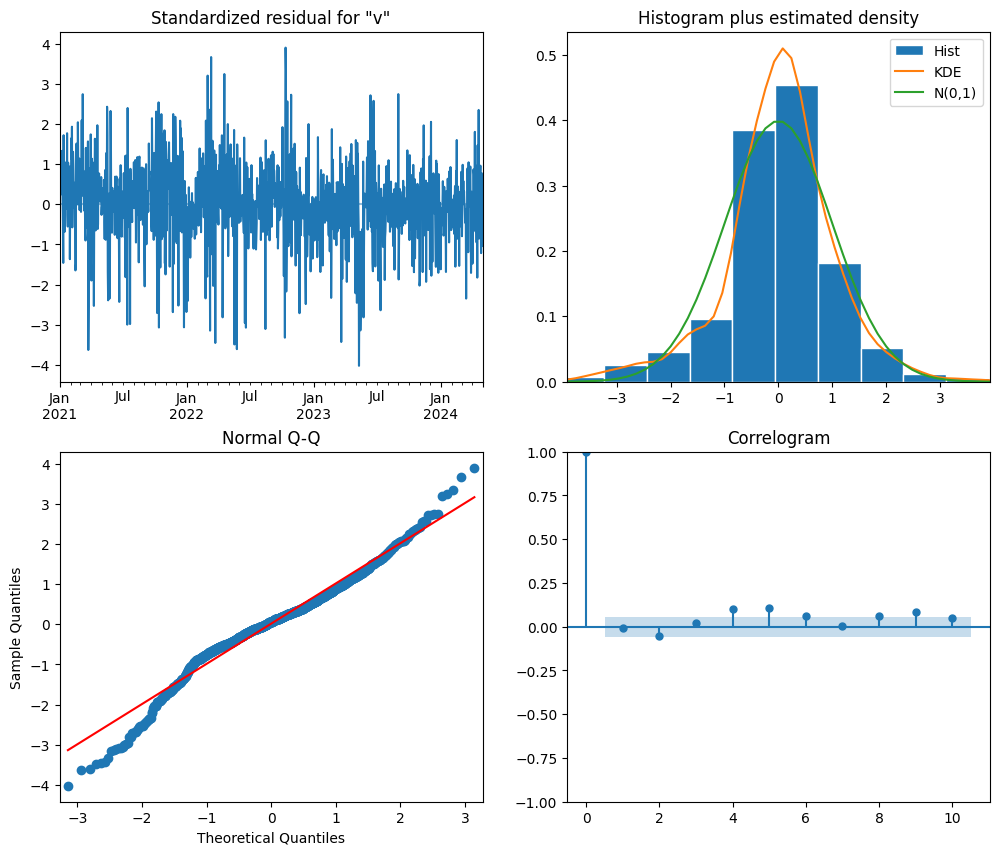

In [28]:
fig_res_2 = resultado_martin.plot_diagnostics(figsize=(12,10))